# Evaluating the models

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision

from trainer import trainer
from dataset.darksound import Darksound
from dataset.sampler import TaskSampler
from networks.protonet import PrototypicalNetworks
from networks.matchnet import MatchingNetworks
from networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

Set the seed for all random packages that could possibly be used

In [2]:
from config import load_config
CONFIG_FILE = 'config.yaml'
params = load_config(CONFIG_FILE)

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Using the pre-trained models

Before using the evaluating the models, one must preprocess the spectrogram (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs. Therefore we use the necessary information for the inference transforms of the pretrained model (ResNet18) with the `weight.transforms` atribute.

In [3]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.IMAGENET1K_V1
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Plot the energy consumption of the optimized models during training in Watt per epoch (We) 

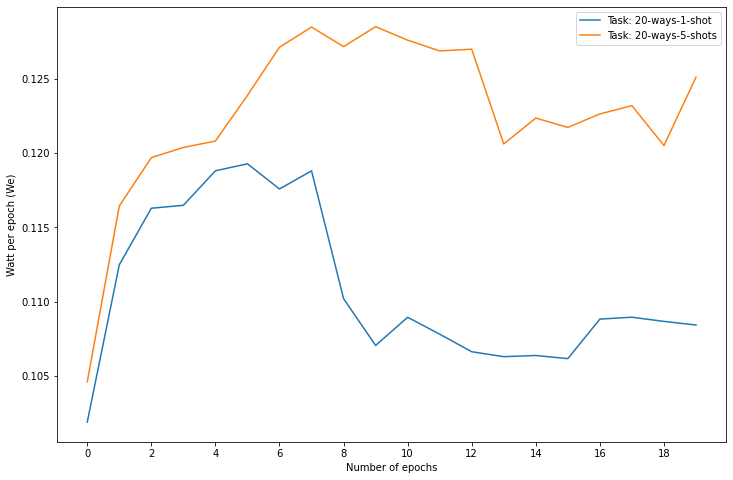

In [5]:
def watt_per_epoch(df_path):
    df = pd.read_csv(df_path, sep=';')
    ujoules = (df.nvidia_gpu_3).to_numpy() # model was trained on GPU 3 only
    joules = ujoules * 1e-6 # convert microjoules to joules
    We = (joules / df.duration.to_numpy()) # convert joules to Watt per epoch (We)
    return We

We1 = watt_per_epoch('models/measurements/matching-networks-20way-1shot-episodic-optimized.csv')
We2 = watt_per_epoch('models/measurements/matching-networks-20way-5shot-episodic-optimized.csv')

plt.figure(figsize=(12,8))
plt.plot(We1, label=f'Task: 20-ways-1-shot')
plt.plot(We2, label=f'Task: 20-ways-5-shots')
plt.xlabel('Number of epochs')
plt.ylabel('Watt per epoch (We)')
plt.xticks(np.arange(0,20,2))
plt.legend();

### Loading the test set and the model to evaluate
Now, we test the model by instantiating a Few-Shot classifier with the trained ResNet as backbone. On the other hand, we also need to flatten once again the last fully connected layer of the ResNet in order to replace it with the Few-Shot classifier.

In [6]:
test_set = Darksound(split='test', hpss=True, remove_background=False, transform=transforms.Compose([weights.transforms()]))
# Load backbone with normalized weights
model = resnet18(weights=weights).to(DEVICE)

# Classical training evaluation
# train_set = Darksound(split='train', hpss=True, remove_background=False, transform=transforms.Compose([weights.transforms()]))
# n_classes = len(set(train_set.__getlabel__()))
# model.fc = nn.Linear(model.fc.in_features, n_classes)
# # model.load_state_dict(torch.load('models/matching-networks-20way-5shot-classical.pt'))
# model.fc = nn.Flatten() # remove fully connected layer for evaluation
# # model = create_feature_extractor(model, return_nodes=['layer4.0.conv2'])
# # model = RelationNetworks(model, use_softmax=False).to(DEVICE)
# model = MatchingNetworks(model, use_softmax=True).to(DEVICE)

# Episodic training evaluation
model.fc = nn.Flatten() # remove fully connected layer for evaluation
model = MatchingNetworks(model, use_softmax=True).to(DEVICE)
# model = create_feature_extractor(model, return_nodes=['layer4.0.conv2'])
# model = RelationNetworks(model, use_softmax=False).to(DEVICE)
model.load_state_dict(torch.load('models/matching-networks-20way-5shot-episodic-optimized.pt'))

<All keys matched successfully>

### Performance metrics evaluation with 5-Fold Cross Validation

In [7]:
n_way = 20
n_shot = 5
n_query = 1
n_test_tasks = 100

# criterion = nn.MSELoss() # for Relation networks
criterion = nn.CrossEntropyLoss()

folds = 5
num_workers = 12
performance = []

for i in range(folds):
    test_sampler = TaskSampler(test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks)
    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=test_sampler.episode,
    )
    # St verbose to True in order to get the performance metrics
    metrics, acc = trainer(model, test_loader, loss_fn=criterion, train=False, verbose=True, device=DEVICE)
    performance.append(pd.DataFrame(metrics))

Evaluating: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, acc=0.796]


In [10]:
df = pd.concat(performance) 
print(f"Accuracy: {df['accuracy'].unique().mean()}")

Accuracy: 0.8003


In [11]:
precision, recall, f1 = [], [], []
for i in range(n_way):
    precision.append(df[str(i)]['precision'].mean())
    recall.append(df[str(i)]['recall'].mean())
    f1.append(df[str(i)]['f1-score'].mean())
    
print(f'Precision: {np.mean(precision)}')
print(f'Recall: {np.mean(recall)}')
print(f'F1-Score: {np.mean(f1)}')

Precision: 0.804614686800984
Recall: 0.8002999999999998
F1-Score: 0.7995483811549917
